In [1]:
import os
#go back one directory
os.chdir("..")
# now go into source directory
os.chdir("source")


In [2]:
from tools.spaceX_ephem_tools import spacex_ephem_to_dataframe, parse_spacex_datetime_stamps, read_spacex_ephemeris, spacex_ephem_to_dataframe
from tools.utilities import yyyy_mm_dd_hh_mm_ss_to_jd

OpenJDK 64-Bit Server VM warning: Attempt to protect stack guard pages failed.
OpenJDK 64-Bit Server VM warning: Attempt to deallocate stack guard pages failed.


In [3]:
# read positions and velocities into orekit.measurement 

In [4]:
import pandas as pd
import numpy as np

In [35]:
def std_dev_from_lower_triangular(lower_triangular_data):
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
    std_dev = np.sqrt(np.diag(cov_matrix))
    return std_dev

def spacex_ephem_to_df_w_cov(ephem_path: str) -> pd.DataFrame:
    """
    Convert SpaceX ephemeris data, including covariance terms, into a pandas DataFrame.

    Parameters
    ----------
    ephem_path : str
        Path to the ephemeris file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing parsed SpaceX ephemeris data, including covariance terms.
    """
    with open(ephem_path) as f:
        lines = f.readlines()

    # Remove header lines and select every 4th line starting from the first data line
    t_xyz_uvw = lines[4::4]

    # Extract t, x, y, z, u, v, w
    t = [float(i.split()[0]) for i in t_xyz_uvw]
    x = [float(i.split()[1]) for i in t_xyz_uvw]
    y = [float(i.split()[2]) for i in t_xyz_uvw]
    z = [float(i.split()[3]) for i in t_xyz_uvw]
    u = [float(i.split()[4]) for i in t_xyz_uvw]
    v = [float(i.split()[5]) for i in t_xyz_uvw]
    w = [float(i.split()[6]) for i in t_xyz_uvw]

    # Extract the 21 covariance terms (3 lines after each primary data line)
    covariance_data = {f'cov_{i+1}': [] for i in range(21)}
    for i in range(5, len(lines), 4):  # Start from the first covariance line
        cov_lines = lines[i:i+3]  # Get the three lines of covariance terms
        cov_values = ' '.join(cov_lines).split()
        for j, value in enumerate(cov_values):
            covariance_data[f'cov_{j+1}'].append(float(value))

    # Convert timestamps to strings and call parse_spacex_datetime_stamps
    t_str = [str(int(i)) for i in t]  # Convert timestamps to string
    parsed_timestamps = parse_spacex_datetime_stamps(t_str)

    # Calculate Julian Dates for each timestamp
    jd_stamps = np.zeros(len(parsed_timestamps))
    for i in range(len(parsed_timestamps)):
        jd_stamps[i] = yyyy_mm_dd_hh_mm_ss_to_jd(int(parsed_timestamps[i][0]), int(parsed_timestamps[i][1]), 
                                                 int(parsed_timestamps[i][2]), int(parsed_timestamps[i][3]), 
                                                 int(parsed_timestamps[i][4]), int(parsed_timestamps[i][5]), 
                                                 int(parsed_timestamps[i][6]))

    # Initialize lists for averaged position and velocity standard deviations
    sigma_positions = []
    sigma_velocities = []

    # Calculate averaged standard deviations for each row
    for _, row in pd.DataFrame(covariance_data).iterrows():
        std_devs = std_dev_from_lower_triangular(row.values)
        sigma_position = np.mean(std_devs[:3])  # Assuming I can average uncertainty in x, y, z
        sigma_velocity = np.mean(std_devs[3:])  # Assuming I can average uncertainty in u, v, w
        sigma_positions.append(sigma_position)
        sigma_velocities.append(sigma_velocity)

    # Construct the DataFrame with all data
    spacex_ephem_df = pd.DataFrame({
        't': t,
        'x': x,
        'y': y,
        'z': z,
        'u': u,
        'v': v,
        'w': w,
        'JD': jd_stamps,
        'sigma_pos': sigma_positions,
        'sigma_vel': sigma_velocities,
        **covariance_data
    })

    spacex_ephem_df['hours'] = (spacex_ephem_df['JD'] - spacex_ephem_df['JD'][0]) * 24 # hours since first timestamp

    return spacex_ephem_df

In [36]:
spacex_ephem_dfwcov = spacex_ephem_to_df_w_cov("/Users/charlesc/Documents/GitHub/ERP_tools/external/ephems/starlink/MEME_57632_STARLINK-30309_3530645_Operational_1387262760_UNCLASSIFIED.txt")

2023 12 19 6 45 42 0
2023 12 19 6 46 42 0
2023 12 19 6 47 42 0
2023 12 19 6 48 42 0
2023 12 19 6 49 42 0
2023 12 19 6 50 42 0
2023 12 19 6 51 42 0
2023 12 19 6 52 42 0
2023 12 19 6 53 42 0
2023 12 19 6 54 42 0
2023 12 19 6 55 42 0
2023 12 19 6 56 42 0
2023 12 19 6 57 42 0
2023 12 19 6 58 42 0
2023 12 19 6 59 42 0
2023 12 19 7 0 42 0
2023 12 19 7 1 42 0
2023 12 19 7 2 42 0
2023 12 19 7 3 42 0
2023 12 19 7 4 42 0
2023 12 19 7 5 42 0
2023 12 19 7 6 42 0
2023 12 19 7 7 42 0
2023 12 19 7 8 42 0
2023 12 19 7 9 42 0
2023 12 19 7 10 42 0
2023 12 19 7 11 42 0
2023 12 19 7 12 42 0
2023 12 19 7 13 42 0
2023 12 19 7 14 42 0
2023 12 19 7 15 42 0
2023 12 19 7 16 42 0
2023 12 19 7 17 42 0
2023 12 19 7 18 42 0
2023 12 19 7 19 42 0
2023 12 19 7 20 42 0
2023 12 19 7 21 42 0
2023 12 19 7 22 42 0
2023 12 19 7 23 42 0
2023 12 19 7 24 42 0
2023 12 19 7 25 42 0
2023 12 19 7 26 42 0
2023 12 19 7 27 42 0
2023 12 19 7 28 42 0
2023 12 19 7 29 42 0
2023 12 19 7 30 42 0
2023 12 19 7 31 42 0
2023 12 19 7 32 42 0
20

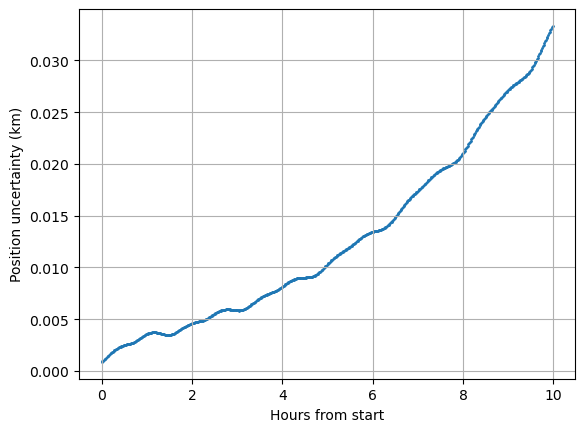

In [55]:
spacex_ephem_dfwcov.head()
import matplotlib.pyplot as plt

#calculate hours from start using spacex_ephem_dfwcov['JD']


plt.scatter(spacex_ephem_dfwcov['hours'][0:600],spacex_ephem_dfwcov['sigma_pos'][0:600], s=1)
plt.xlabel('Hours from start')
plt.ylabel('Position uncertainty (km)')
plt.grid()
# plt.plot(spacex_ephem_dfwcov['JD'],spacex_ephem_dfwcov['sigma_vel'])

In [ ]:
from orekit.pyhelpers import datetime_to_absolutedate, JArray
from org.orekit.estimation.measurements import ObservableSatellite, PV

observableSatellite = ObservableSatellite(0) # Propagator index = 0
orekitRange = PV()
                    observableSatellite
                ) # Uses date of signal reception; https://www.orekit.org/static/apidocs/org/orekit/estimation/measurements/Range.html
            # estimator.addMeasurement(orekitRange)


In [40]:
import numpy as np
def create_symmetric_corr_matrix(lower_triangular_data):
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
    std_dev = np.sqrt(np.diag(cov_matrix))
    return std_dev

# Extract covariance data for the first record as an example
cov_data = spacex_ephem_dfwcov.iloc[0, 7:].values

# Calculate standard deviations
std_devs = create_symmetric_corr_matrix(cov_data)

# Separate standard deviations for position (x, y, z) and velocity (u, v, w)
sigma_position = np.mean(std_devs[:3]) # Assuming equal uncertainty in x, y, z
print("sigma pos: ", sigma_position)
sigma_velocity = np.mean(std_devs[3:]) # Assuming equal uncertainty in u, v, w
print("sigma vel: ", sigma_velocity)

sigma pos:  0.0008759577135888617
sigma vel:  1.4665412939723329e-06


In [ ]:
from orekit.pyhelpers import datetime_to_absolutedate
from org.orekit.estimation.measurements import PV, ObservableSatellite
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.time import AbsoluteDate
import pandas as pd

# Assuming spacex_ephem_df is your DataFrame from spacex_ephem_to_df_w_cov function

# Convert first 5 data points
for index, row in spacex_ephem_df.head(5).iterrows():
    # Convert time to AbsoluteDate (assuming 't' is in seconds since epoch)
    date = AbsoluteDate(row['t'])

    # Convert position and velocity to Vector3D
    position = Vector3D(row['x'], row['y'], row['z'])
    velocity = Vector3D(row['u'], row['v'], row['w'])

    # Set standard deviations and base weight (these are placeholders)
    sigmaPosition = 1.0  # Replace with actual value
    sigmaVelocity = 1.0  # Replace with actual value
    baseWeight = 1.0     # Replace with actual value

    # Create an instance of ObservableSatellite (assuming single satellite with index 0)
    observableSatellite = ObservableSatellite(0)

    # Create PV instance
    orekitPV = PV(date, position, velocity, sigmaPosition, sigmaVelocity, baseWeight, observableSatellite)

    # Use orekitPV as required in your application


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import SymLogNorm

# Create the output directory if it doesn't exist
output_dir = "output/covariance_heatmaps/starlink"
os.makedirs(output_dir, exist_ok=True)

# Function to create a symmetric correlation matrix from lower triangular covariance elements
def create_symmetric_corr_matrix(lower_triangular_data):
    # Create the symmetric covariance matrix
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())

    # Convert to correlation matrix
    std_dev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = np.divide(cov_matrix, std_dev[:, None])
    corr_matrix = np.divide(corr_matrix, std_dev[None, :])
    np.fill_diagonal(corr_matrix, 1)  # Fill diagonal with 1s for self-correlation
    return corr_matrix

# Axis labels
axis_labels = ['x', 'y', 'z', 'u', 'v', 'w']
# Assuming spacex_ephem_dfwcov is your DataFrame and it contains columns 'cov_1' to 'cov_21'
all_cov_data = spacex_ephem_dfwcov.loc[:, 'cov_1':'cov_21'].values

# Iterate through the first 1000 items
filenames = []
for i in range(min(1000, len(spacex_ephem_dfwcov))):
    # Create the symmetric correlation matrix
    corr_matrix = create_symmetric_corr_matrix(all_cov_data[i, :])

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(corr_matrix, annot=True, cmap='viridis', xticklabels=axis_labels, yticklabels=axis_labels, vmin=-1, vmax=1)
    plt.title(f'Starlink-57632 Correlation: {(spacex_ephem_dfwcov.loc[i, "t"])}')

    # Save the heatmap to a file
    filename = f'{output_dir}/spacex_corr_hm{i}.png'
    plt.savefig(filename, dpi=64)
    filenames.append(filename)
    plt.close()

import imageio

def create_animation(filenames, animation_path):
    images = [imageio.imread(filename) for filename in filenames]
    imageio.mimsave(animation_path, images, duration=0.1)

# Path for the output GIF
animation_path = "output/covariance_heatmaps/starlink/spacex_corr_heatmaps.gif"

# Create the animation
create_animation(filenames, animation_path)